## Predicting Graduate Admissions using Deep Learning

This is a simple example on how to implement Neural Networks for predictions. \
We use tha Kaggle dataset: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions

The dataset contains several parameters which are considered important during the application for Masters Programs.\
We construct a Neural Network that predicts the probability of getting admitted.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the data
data = pd.read_csv('data/admissions_data.csv')
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [4]:
features = data.drop(columns=['Chance of Admit '])
labels = data.iloc[:,-1] # Choose the final column for prediction

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=32)

# Scale the data (since each entry has a different range)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [5]:
# Design the model
model = Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mse', metrics='mae', optimizer=opt)

# Train the model
hist = model.fit(X_train, Y_train, epochs=200, batch_size=20, validation_split=0.2, verbose=0) 

In [7]:
# Evaluate the model
loss, mae = model.evaluate(X_test, Y_test, verbose=1)
print('\nloss =', loss, '\nMAE =', mae)

1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - mae: 0.0629

5/5 [==============================] - 0s 3ms/step - loss: 0.0054 - mae: 0.0566

loss = 0.005366860423237085 
MAE = 0.056585781276226044


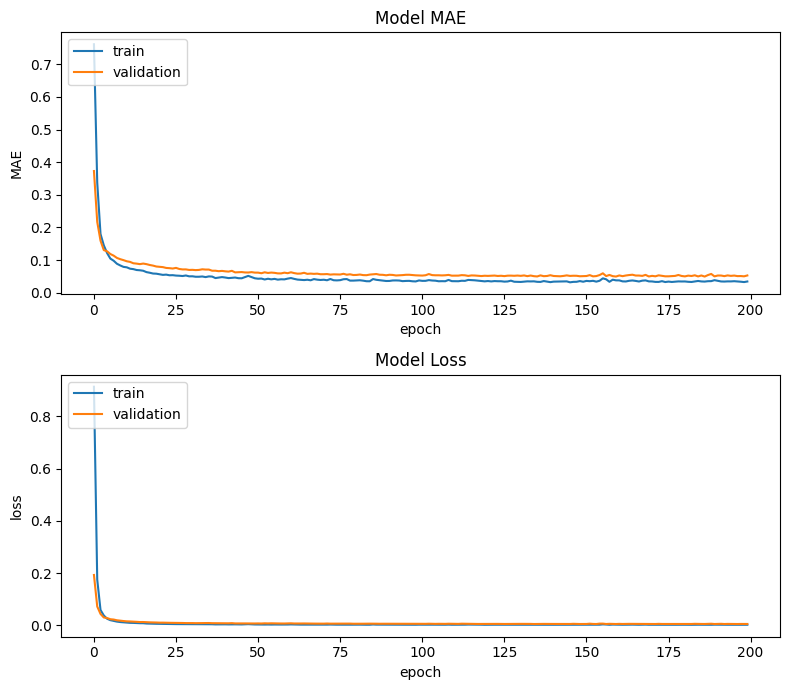

In [8]:
# Plot MSE as a function of epochs
fig = plt.figure(figsize=(8,7)) 
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(hist.history['mae'])
ax1.plot(hist.history['val_mae'])
ax1.set_title('Model MAE')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
 
# Plot loss and val_loss as a function of epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
 
# We save the plot as a png file 
fig.tight_layout()
fig.savefig('plot_results.png')

**$R^2$ error**

The $R^2$ error or Coefficient of Determination is a way to evaluate a regression model.\
The residual sum of squares is given by
$$ SS_{\rm res} = \sum_i (y_i-f_i)^2$$
where $y_i$ corresponds to the true values, while $f_i$ to the predicted values. The total sum of squares is
$$ SS_{\rm tot} = \sum_i (y_i-\bar{y}_i)^2$$


The $R^2$ coefficient is defined by:
$$ R^2 = 1 - \frac{SS_{\rm res}}{SS_{\rm tot}} $$

Therefore, if $R^2=1$ is a perfect model.\
If the prediction is always close to the mean $\bar{y}$, the model is not so good and $R^2=0$.\
If $R^2<0$ then it is a poor model with large errors.

In [9]:
# R^2 score
Y_predict = model.predict(X_test) 
print(r2_score(Y_test, Y_predict)) 

5/5 [==============================] - 0s 2ms/step
0.7837701199655406


**Real vs Predicted**

We present a histogram that compares the real values with the predicted values from the model.\
The model is good at predicting values > 0.65. \
However, for smaller values tha 0.65 the predictions are not as good.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


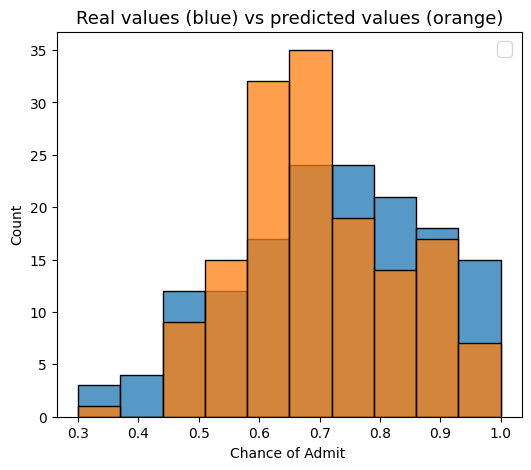

In [10]:
y_pred = pd.Series(Y_predict[:,0])
fig = plt.figure(figsize=(6,5)) 
plt.title('Real values (blue) vs predicted values (orange)', fontsize=13, color='black') 
sns.histplot(x=Y_test, bins=10, binrange=(0.3,1))
sns.histplot(x=y_pred, bins=10, binrange=(0.3,1))
plt.legend(prop={'size':14})

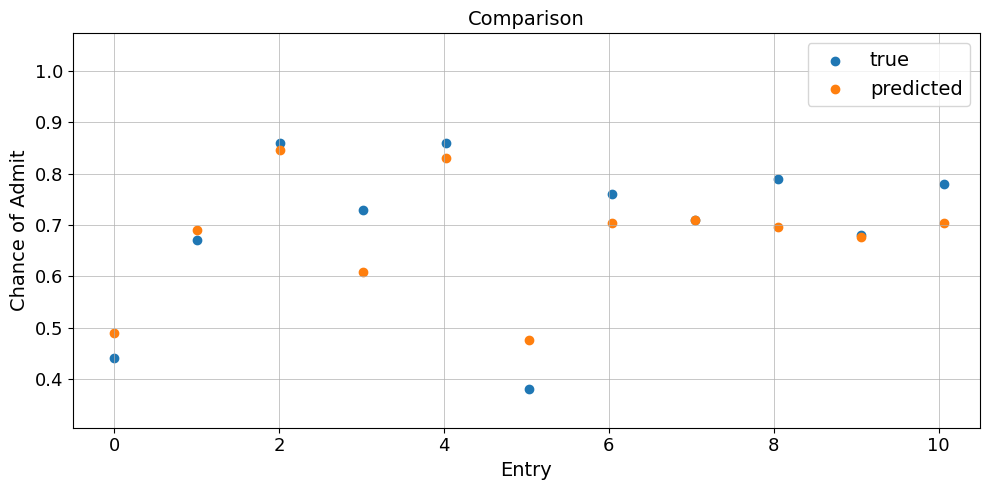

In [11]:
# Let's compare the predicted and true values for the first 10 entries
fig = plt.figure(figsize=(10,5)) 
ax = fig.gca()
xx = np.linspace(0, len(Y_test), len(Y_test))
plt.scatter(xx, Y_test, label='true')
plt.scatter(xx, Y_predict, label='predicted')
ax.set_xlim(-0.5,10.5)
plt.xticks(fontsize = 13) 
plt.yticks(fontsize = 13) 

ax.set_ylabel('Chance of Admit', fontsize=14)
ax.set_xlabel('Entry', fontsize=14)

plt.grid(linewidth=0.5)

plt.legend(prop={'size':14})
plt.title('Comparison', fontsize=14, color='black') 
plt.tight_layout()

plt.show()
fig.savefig('test.png')